# **pipline to try continuous output**

In [6]:
#Data Manipulation
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats import zscore, loguniform, randint
import math

#Data visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
colors = ['#c1121f','#669bbc', '#f4d35e', '#e9724c', '#ffc857']
plt.style.use('seaborn-white')
plt.rc('figure', figsize=(12,8))
plt.rc('font', size=18)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Preprocessing
from sklearn.model_selection import train_test_split
import sklearn.utils
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Models
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#Metrics and Tuning
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from yellowbrick.regressor import PredictionError, ResidualsPlot

#General
import os
from google.colab import files
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
df = pd.read_csv("/content/data_after_processing_all_100_factors.csv")
df.head()

,Country,People using safely managed drinking water services % of population 2017,People using safely managed sanitation services % of population 2017,Access to electricity % of population 2017,Renewable energy consumption % of total final energy consumption 2015_x,Expenditures for R&D % of GDP 2015,Urban population living in slums % of urban population 2014,Ambient PM2.5 air pollution mean annual exposure micrograms per cubic meter 2016,Adjusted net savings % of GNI 2017,Carbon dioxide emissions per capita metric tons 2014_x,Nationally protected terrestrial and marine areas % of total territorial area 2018,"Intentional homicides Combined source estimates per 100,000 people 2015",Internet use Individuals using the Internet % of population 2017,Rural population % of total 2000,Rural population % of total 2018,Rural population growth (annual %) 2018,Land area sq. km thousands 2016,Land use Forest area % of land area 2000,Land use Forest area % of land area 2016,Land use Permanent cropland % of land area 2000,Land use Permanent cropland % of land area 2016,Land use Arable land % of land area 2000,Land use Arable land % of land area 2016,Arable land hectares per person 2000,Arable land hectares per person 2016,Access to electricity % of population 2000,Access to electricity % of population 2016,Access to electricity % of urban population 2016,Access to electricity % of rural population 2016,Access to clean fuels and technologies for cooking % of population 2000,Access to clean fuels and technologies for cooking % of population 2016,Renewable energy consumption % of total final energy consumption 2000,Renewable energy consumption % of total final energy consumption 2015_y,Renewable electricity output % of total electricity output 2000,Renewable electricity output % of total electricity output 2015,Agricultural land % of land area 2000-02,Agricultural land % of land area 2014-16,Agricultural land % irrigated 2014-16,Average annual precipitation millimeters 2014,Land under cereal production hectares thousands 2000-02,Land under cereal production hectares thousands 2014-16,Fertilizer consumption % of fertilizer production 2014-16,Fertilizer consumption kilograms per hectare of arable land 2014-16,Agricultural employment % of total employment 2000-02,Agricultural employment % of total employment 2014-16,Agricultural machinery tractors per 100 sq. km of arable land 2000,Agricultural machinery tractors per 100 sq. km of arable land 2009,Exposure to impact Land area where elevation is below 5 meters % of land area 2010,Exposure to impact Population living in areas where elevation is below 5 meters % of total population 2010,"Exposure to impact Population affected by droughts, floods, and extreme temperatures average annual; % of total population 2009",Exposure to impact Urban land area where elevation is below 5 meters % of urban land area 2010,Exposure to impact Rural population living in areas where elevation is below 5 meters % of rural population 2010,Exposure to impact Rural land area where elevation is below 5 meters % of rural land area 2010,Exposure to impact Urban population living in areas where elevation is below 5 meters % of urban population 2010,"Resilience Disaster risk reduction progress score 1, worst to 5,best 2011",Net energy imports % of energy use 1990,Net energy imports % of energy use 2015,GDP per unit of energy use 2011 PPP $ per kilogram of oil equivalent 1990,GDP per unit of energy use 2011 PPP $ per kilogram of oil equivalent 2015,Carbon dioxide emissions Total thousand metric tons 1990,Carbon dioxide emissions Total thousand metric tons 2014,Carbon dioxide emissions Carbon intensity kilograms per kilograms of oil equivalent energy use 1990,Carbon dioxide emissions Carbon intensity kilograms per kilograms of oil equivalent energy use 2014,Carbon dioxide emissions per capita metric tons 1990,Carbon dioxide emissions per capita metric tons 2014_y,Carbon dioxide emissions kilograms per 2011 PPP $ of GDP 1990,Carbon

In [8]:
print('------ Dataset ------')
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

------ Dataset ------
Number of rows: 214
Number of columns: 101


In [9]:
df.set_index("Country", inplace = True)

In [10]:
# defining x and y
X= df.drop(columns=['Incidence of tuberculosis per 100,000 people 2018','output'])
y = df['Incidence of tuberculosis per 100,000 people 2018']

In [11]:
 #Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=18)

# Pipeline
A pipeline function will be created, which will contain a Pipeline object with all the transformations that were described earlier. This function will receive a regression model as an argument, which will be included in the final pipeline. The final pipeline will be composed of the preprocessing steps and the regression.

In [12]:
#Pass this function inside FunctionTransformer instead of passing just np.log to avoid cases with values equal zerodef log_transform(X):
def log_transform(X):
    return np.log(X + 10e-5)

In [13]:
#Class to replace outliers
class OutliersRemover(BaseEstimator, TransformerMixin):
    def __init__(self, baseline=1.5):
        self.baseline = baseline

    def fit(self, X, y=None):
        X = check_array(X, force_all_finite=False) #If non-array, transform into an array
        q1 = np.nanquantile(X, 0.25, axis=0) #First quartile
        q3 = np.nanquantile(X, 0.75, axis=0) #Third quartile
        IQR = q3 - q1
        self.lower_bound = q1 - (self.baseline * IQR)
        self.upper_bound = q3 + (self.baseline * IQR)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X, y=None):
        check_is_fitted(self)
        X = check_array(X, force_all_finite=False)
        assert self.n_features_in_ == X.shape[1]
        X_transformed = X.copy()
        X_transformed = np.where(((X_transformed < self.lower_bound) | (X_transformed > self.upper_bound)),
                                 np.nan,
                                 X_transformed)


        return X_transformed #Returns an array

In [14]:
def pipeline(regressor):
    # define list of features that are known to be skewed in the dataset
    skewed_features = ['Access to electricity % of population 2017',
                       'Land use Permanent cropland % of land area 2000',
                       'Access to electricity % of population 2016',
                       'Access to electricity % of urban population 2016',
                        'Access to electricity % of rural population 2016',
                       'Land area sq. km thousands 2016']

    # define list of numerical features that are not skewed
    numerical_features = [feature for feature in X_train.columns
                        if feature not in skewed_features]

    # define pipeline for numerical features
    numerical_transformer = Pipeline(
        steps=[
            ('outliers', OutliersRemover()), # remove outliers from data
            ('impute', KNNImputer()), # impute missing values using K-Nearest Neighbors
            ('scaling', StandardScaler()), # scale features to have mean 0 and unit variance
        ]
    )

    # define pipeline for skewed features
    skewed_transformer = Pipeline(
        steps=[
            ('outliers', OutliersRemover()), # remove outliers from data
            ('log', FunctionTransformer(log_transform)), # apply natural logarithm transformation to skewed features
            ('impute', KNNImputer()), # impute missing values using K-Nearest Neighbors
            ('scaling', StandardScaler()), # scale features to have mean 0 and unit variance
        ]
    )

    # define ColumnTransformer to apply each pipeline to appropriate features
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_transformer', numerical_transformer, numerical_features), # apply numerical pipeline to numerical features
            ('skewed_transformer', skewed_transformer, skewed_features) # apply skewed pipeline to skewed features
        ],
        remainder='passthrough' # pass through any remaining features
    )

    # define final pipeline, consisting of preprocessor and regressor
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor), # apply preprocessor to data
            ('regressor', regressor) # apply regressor to preprocessed data
        ]
    )

    return model

# **Modeling**
- First, a set of regressors with default parameters will be tested and evaluated. The models that perform better in cross-validation will be tuned using RandomizedSearchCV().

- For this problem, the Root Mean Squared Error (RMSE) and R-squared will be used as performance metrics.

In [15]:
#Dict with the regressors
models = {
    "Linear Regression (Ridge)": pipeline(Ridge()),
    "Decision Tree": pipeline(DecisionTreeRegressor()),
    "Support Vector Regression": pipeline(SVR()),
    "Neural Network": pipeline(MLPRegressor()),
    "Random Forest": pipeline(RandomForestRegressor()),
    "Gradient Boosting": pipeline(XGBRegressor())
}
#Function that performs cross validation on the model and returns the mean of RMSE and R^2 for that model.
def evaluate_model(model, X_train, y_train):

    cv = cross_validate(model,
                        X_train, y_train,
                        cv = 5,
                        scoring = ('neg_root_mean_squared_error','r2'))

    return np.mean(-cv['test_neg_root_mean_squared_error']), np.mean(cv['test_r2'])

In [16]:
#Run all models through cross validation and get the mean of each one.
models_name = []
models_rmse = []
models_r2 = []

for name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train, y_train)
    models_name.append(name)
    models_rmse.append(rmse)
    models_r2.append(r2)

df_models = pd.DataFrame(data =
                         {'Mean RMSE in CV' : models_rmse,
                          'Mean R2 in CV' : models_r2
                         },
                         index = models_name)

In [17]:
#Mean performance of each model in cross-validation.
display(df_models)

,Mean RMSE in CV,Mean R2 in CV
Linear Regression (Ridge),158.005214,-0.519670
Decision Tree,143.319402,-0.150871
Support Vector Regression,147.351736,-0.202972
Neural Network,126.619884,0.131144
Random Forest,105.787252,0.398037
Gradient Boosting,120.122493,0.204007


In [18]:
#Function to plot feature importance provided the models.
def plot_feature_importance(df):

    df = df.sort_values(by = '% Importance',
                                ascending = False).copy()

    df_temp = df['% Importance'].sort_values()

    display(df)

    fig, ax = plt.subplots(figsize=(16,16))

    bar = ax.barh(df_temp.index,
                 df_temp,
                 align = ('center'),
                 color =colors[0],
                 height = 0.9)

    ax.bar_label(bar, fmt = '%.f%%', padding=2)
    ax.set_xlabel('Importance (%)')
    ax.set_title('Feature Importance \n', fontsize=18);

,% Importance
Arable land hectares per person 2000,16.369260
Land use Arable land % of land area 2016,12.179595
Arable land hectares per person 2016,6.546474
People using at least basic drinking water services Urban % of urban population 2018,4.833803
"Health workers Nurses and midwives per 1,000 people 2009-18",4.464226
...,...
Exposure to impact Population living in areas where elevation is below 5 meters % of total population 2010,0.000000
Expenditures for R&D % of GDP 2015,0.000000
Water productivity % of domestic 2015,0.000000
Exposure to impact Urban population living in areas where elevation is below 5 meters % of urban population 2010,0.000000


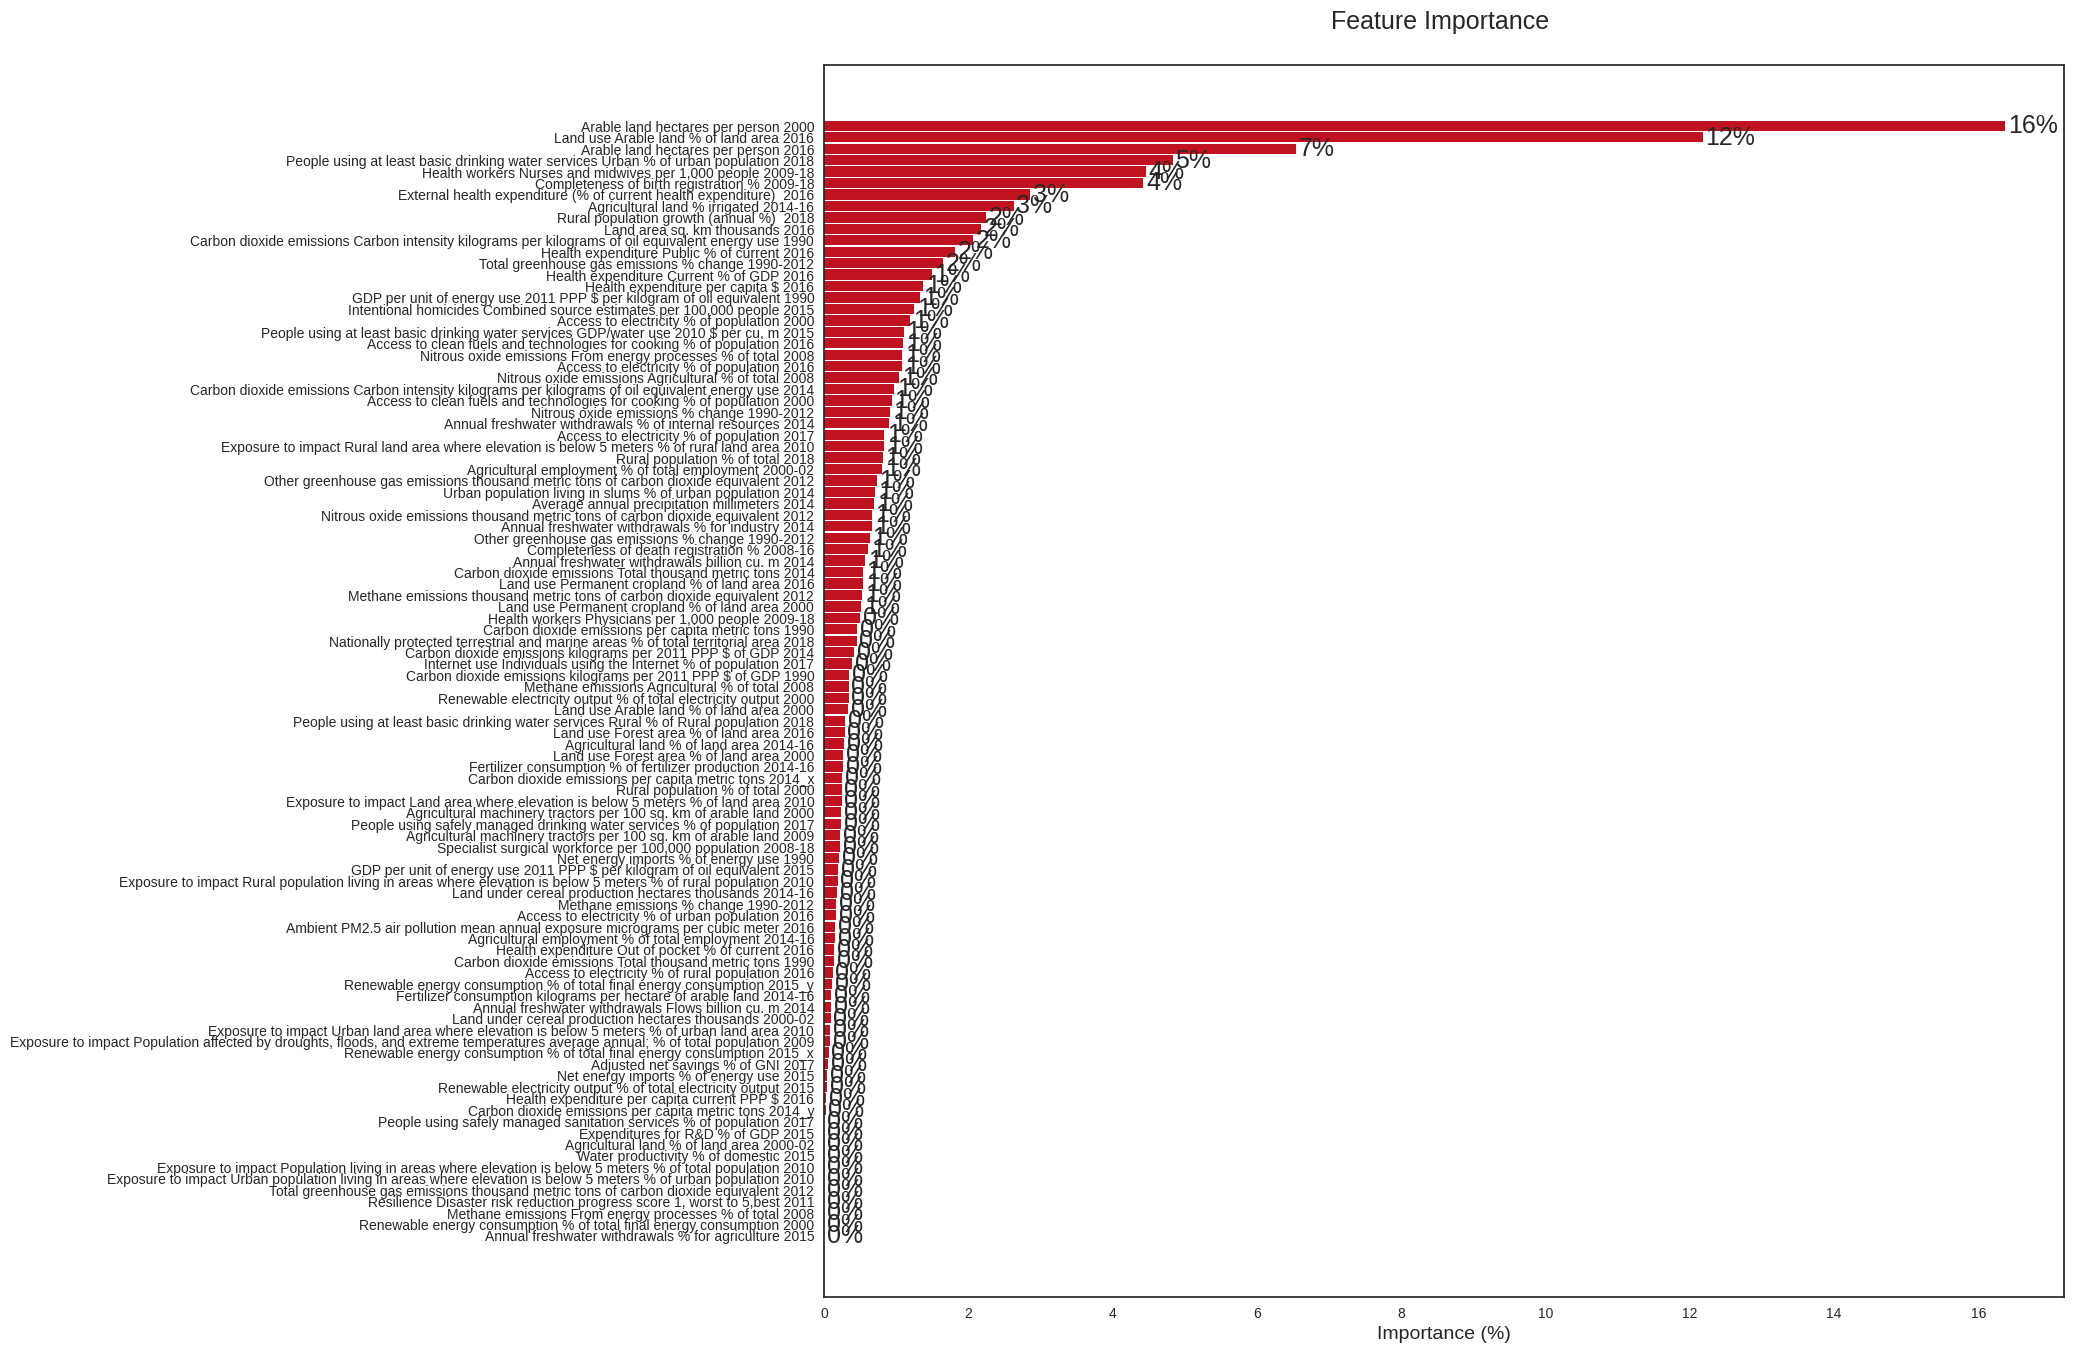

import numpy as np
from google.colab import autoviz
df_4335821669977257030 = autoviz.get_df('df_4335821669977257030')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4335821669977257030, *['% Importance'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1431668013505355704 = autoviz.get_df('df_1431668013505355704')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1431668013505355704, *['% Importance'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [19]:
#Check the feature importance for Random Forest Model
models['Random Forest'].fit(X_train, y_train)

df_feature_importance = pd.DataFrame(data = 100* models['Random Forest']['regressor'].feature_importances_,
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

# **Tune Model**
- With the best models defined, parameter tuning will be performed using Randomized Search.

- Lasso regression model will be used instead of the decision tree. Lasso is a model that uses gradient descent to adjust parameters and ℓ1 regularization technique.

# **Randomized Search**

In [20]:
def random_search(model, param_distribs,X_train, y_train):

    rnd_search = RandomizedSearchCV(model,
                                    param_distributions = param_distribs,
                                    n_iter = 10,
                                    cv = 3,
                                    scoring = 'neg_root_mean_squared_error', # The performance metric to optimize
                                    random_state = 18)


    search = rnd_search.fit(X_train, y_train)

    # Return the best performance score and corresponding hyperparameters found by the search
    return (-search.best_score_) , (search.best_params_)

In [21]:
# Define dictionary with the best models to be tuned
best_models  = {
    "Linear Regression(Ridge)": pipeline(Ridge()),
    "Random Forest": pipeline(RandomForestRegressor()),
    "Gradient Boosting": pipeline(XGBRegressor())
}

# Define a dictionary with the hyperparameters to be searched for each model
param_distribs = {
    "Linear Regression(Ridge)": {
        "regressor__alpha": loguniform(1e-5, 100)
    },
    "Random Forest": {
        "regressor__n_estimators": randint(100, 1000),
        "regressor__max_features": ['auto', 'sqrt'],
        "regressor__max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
        "regressor__min_samples_split": [2, 5, 10],
        "regressor__min_samples_leaf": [1, 2, 4],
        "regressor__bootstrap": [True, False]
    },
    "Gradient Boosting": {
        "regressor__learning_rate": [0.01, 0.1, 0.5, 1],
        "regressor__n_estimators": randint(100, 1000),
        "regressor__max_depth": [3, 5, 7, 9],
    }
}

# Define variables to keep track of the best score, parameters and model
best_score = np.inf
best_param = None
dict_best_models = {}

# Loop through each model and perform a randomized search for hyperparameters
for name, model in best_models.items():
    # Call random_search function to optimize hyperparameters for the current model
    score, param = random_search(model, param_distribs[name], X_train, y_train)
    # Add the best model score to the dictionary
    dict_best_models.update({model['regressor']: score})

    # Check if the score for the current model is better than the best score so far
    if score < best_score:
        best_score = score
        best_param = param
        best_model = model

In [22]:
list_best_models = list(dict_best_models.items())

#Extract the name of the models
list_best_models_renamed = [str(list_best_models[0][0])[:5],
                            str(list_best_models[1][0])[:21],
                            str(list_best_models[2][0])[:12]]

# Extract the score for each model
list_best_models_score = [score[1] for score in list_best_models]

# Extract the score for each model
df_best_models = pd.DataFrame(data = list_best_models_score,
                             index = list_best_models_renamed,
                             columns = ['RMSE'])
display(df_best_models)

,RMSE
Ridge,117.298356
RandomForestRegressor,109.423606
XGBRegressor,121.841504


# Validation
With the model that performed best in the RandomizedSearchCV, the performance will be evaluated using the test data, which are completely new to the model.

In [23]:
best_param = {param.replace('regressor__', ''): value for param, value in best_param.items()}

final_model = pipeline(XGBRegressor(**best_param))
final_model.fit(X_train, y_train)

display(final_model)

[01:27:22] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('outliers',
                                                                   OutliersRemover()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['People using safely '
                                                   'managed drinking water '
                                                   'services % of population '
                                                   '2017',
                                                   'People using safely '
                                                   'managed sanitation '
                                                   'services % of population '
                                                   '2...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=80, max_features='auto',
                              max_leaves=None, min_child_weight=None,
                              min_samples_leaf=2, min_samples_split=5,
                              missing=nan, monotone_constraints=None,
                              n_estimators=890, ...))])

In [24]:
#Test the best model first in cross-validation, to evaluate if there was an increase in the average performance
rmse_train_final_model, r2_train_final_model = evaluate_model(final_model,X_train, y_train)

df_final_model_cv = pd.DataFrame(data = [rmse_train_final_model, r2_train_final_model],
                              index = ['RMSE', 'R2'],
                              columns = ['Final Model Performance in CV'])

display(df_final_model_cv)

[01:27:25] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[01:27:25] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[01:27:26] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[01:27:27] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[01:27:28] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



,Final Model Performance in CV
RMSE,125.363319
R2,0.123058


In [25]:
y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

df_final_model = pd.DataFrame(data = [rmse, r2],
                              index = ['RMSE', 'R2'],
                              columns = ['Final Model Performance in Test'])

df_final_model

,Final Model Performance in Test
RMSE,118.119107
R2,0.162201


,% Importance
Arable land hectares per person 2000,20.990484
Land use Arable land % of land area 2016,19.387880
Completeness of birth registration % 2009-18,10.180272
Carbon dioxide emissions kilograms per 2011 PPP $ of GDP 1990,7.315917
Other greenhouse gas emissions thousand metric tons of carbon dioxide equivalent 2012,6.981236
...,...
Annual freshwater withdrawals % for agriculture 2015,0.000000
GDP per unit of energy use 2011 PPP $ per kilogram of oil equivalent 2015,0.000000
"Resilience Disaster risk reduction progress score 1, worst to 5,best 2011",0.000000
Exposure to impact Urban population living in areas where elevation is below 5 meters % of urban population 2010,0.000000


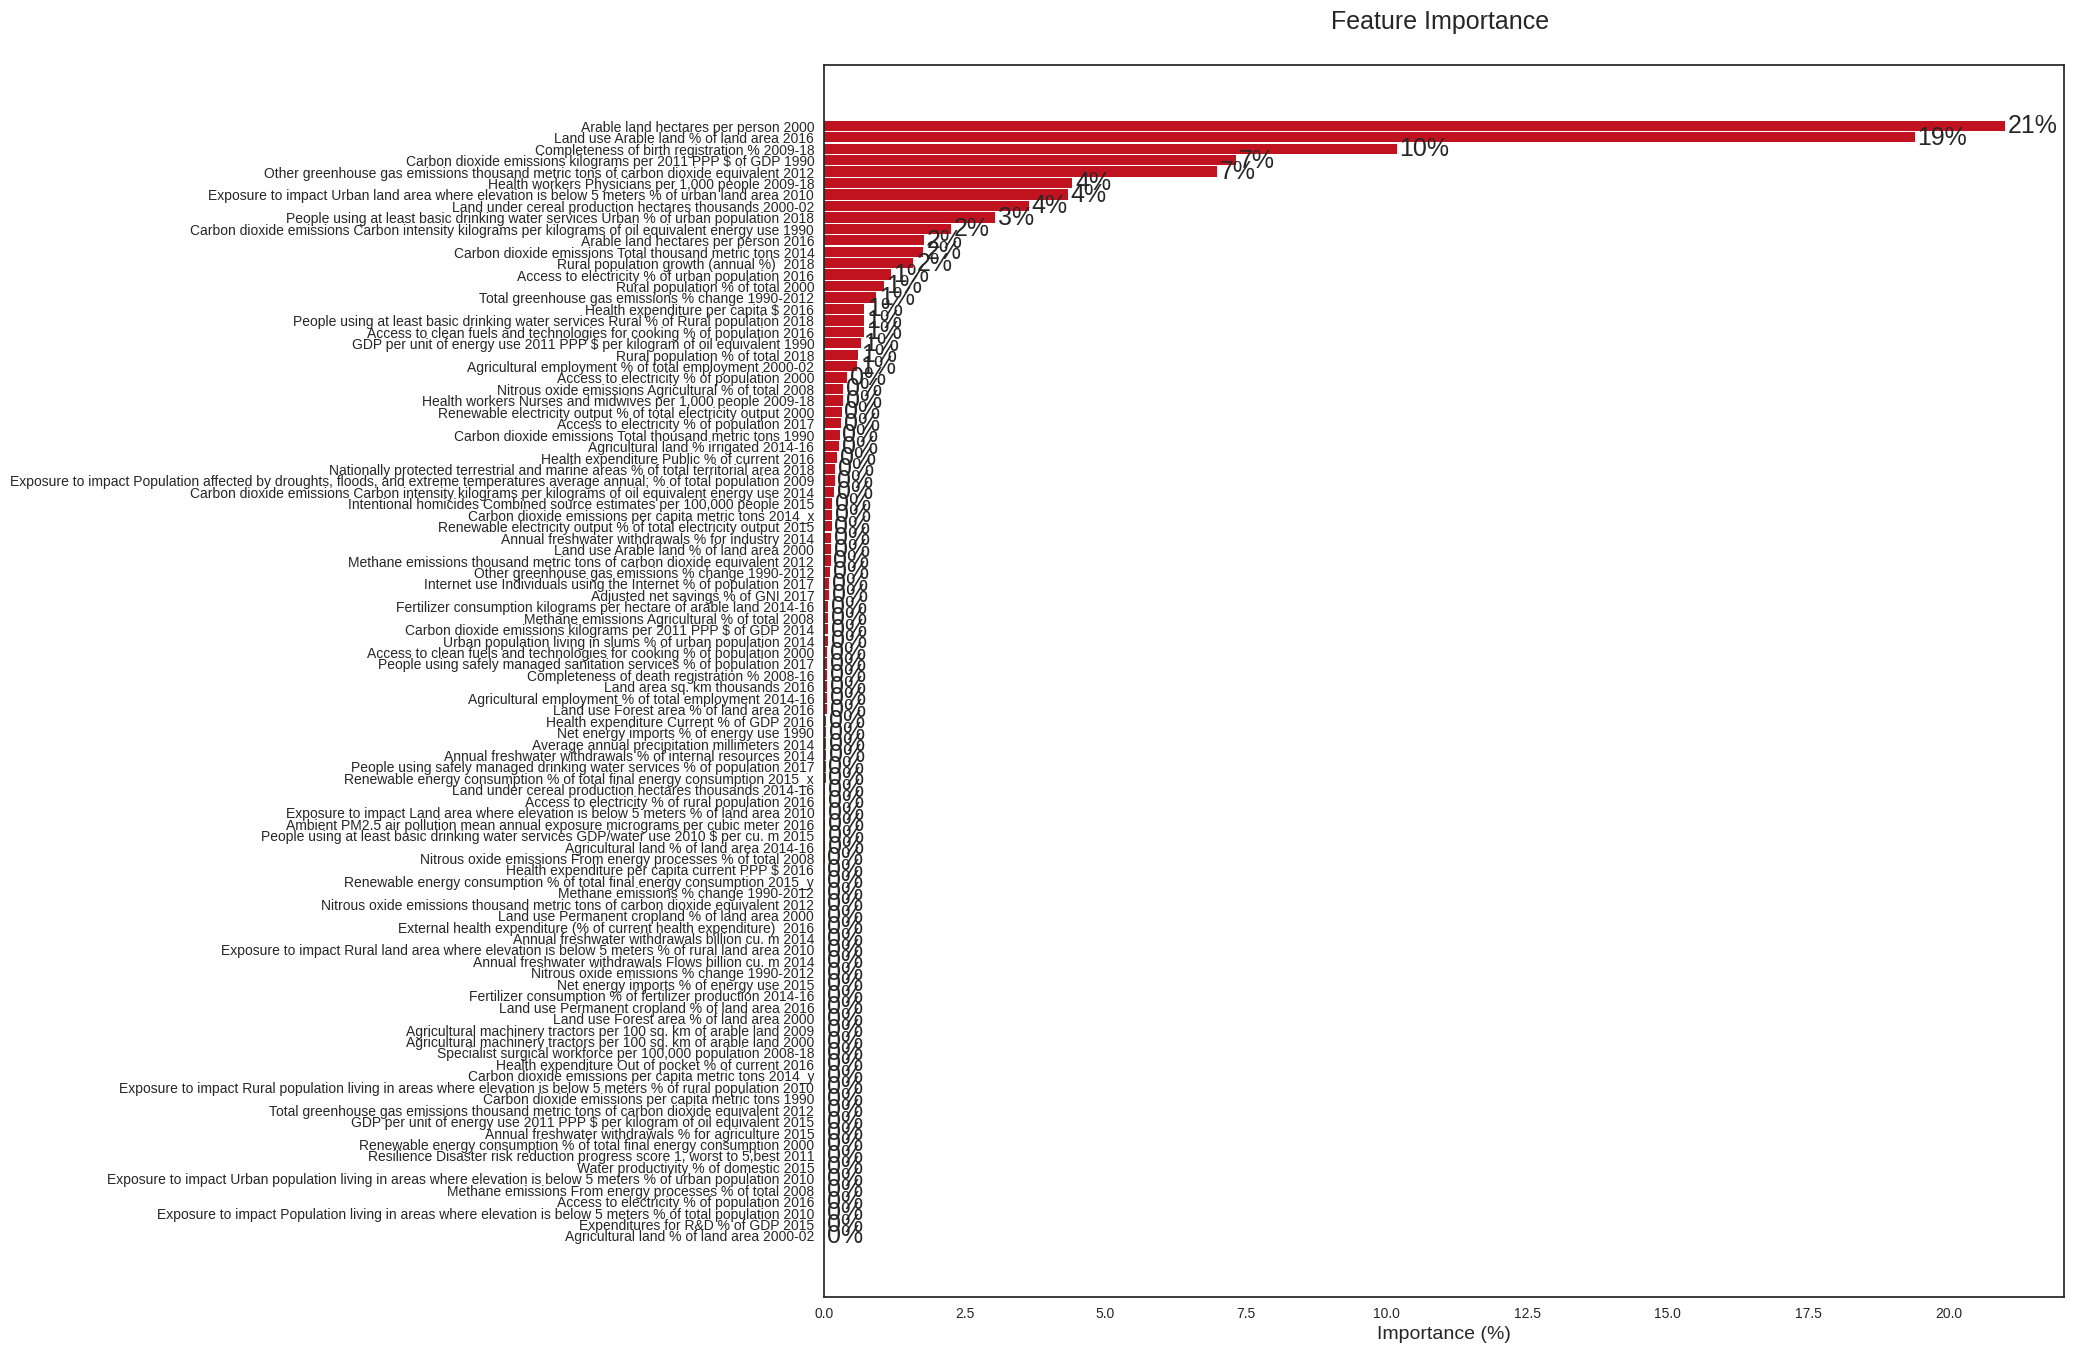

In [26]:
df_feature_importance = pd.DataFrame(data = 100* final_model['regressor'].feature_importances_,
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

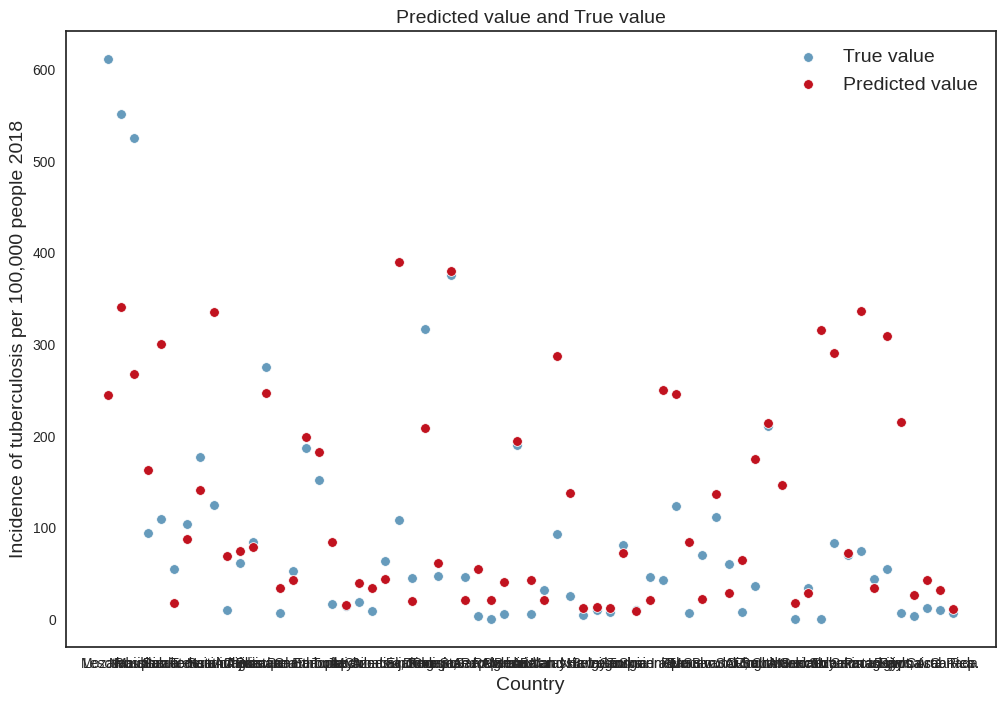

In [27]:
sns.scatterplot(x = X_test.index, y = y_test, color=colors[1], label = "True value")
sns.scatterplot(x = X_test.index, y = y_pred, color=colors[0], label = "Predicted value");

plt.title('Predicted value and True value');

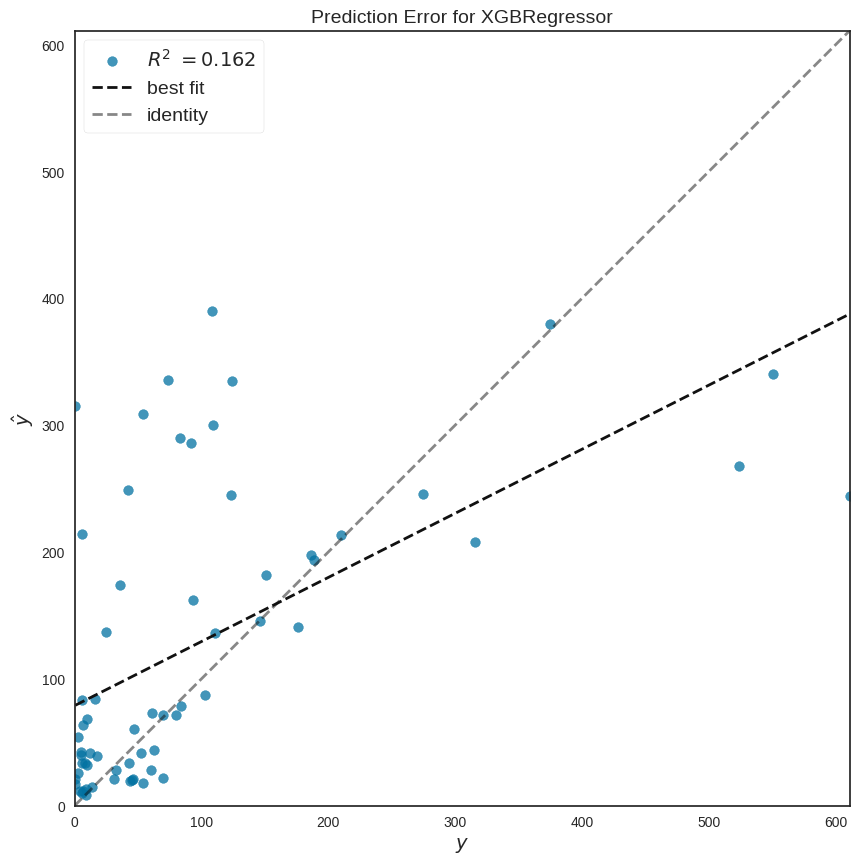

In [28]:
#Plot prediction error
fig, ax = plt.subplots(figsize=(10,12))

pred_error = PredictionError(final_model, scatter_kwargs={'color': 'red'})
pred_error.fit(X_train, y_train)
pred_error.score(X_test, y_test)
pred_error.show();

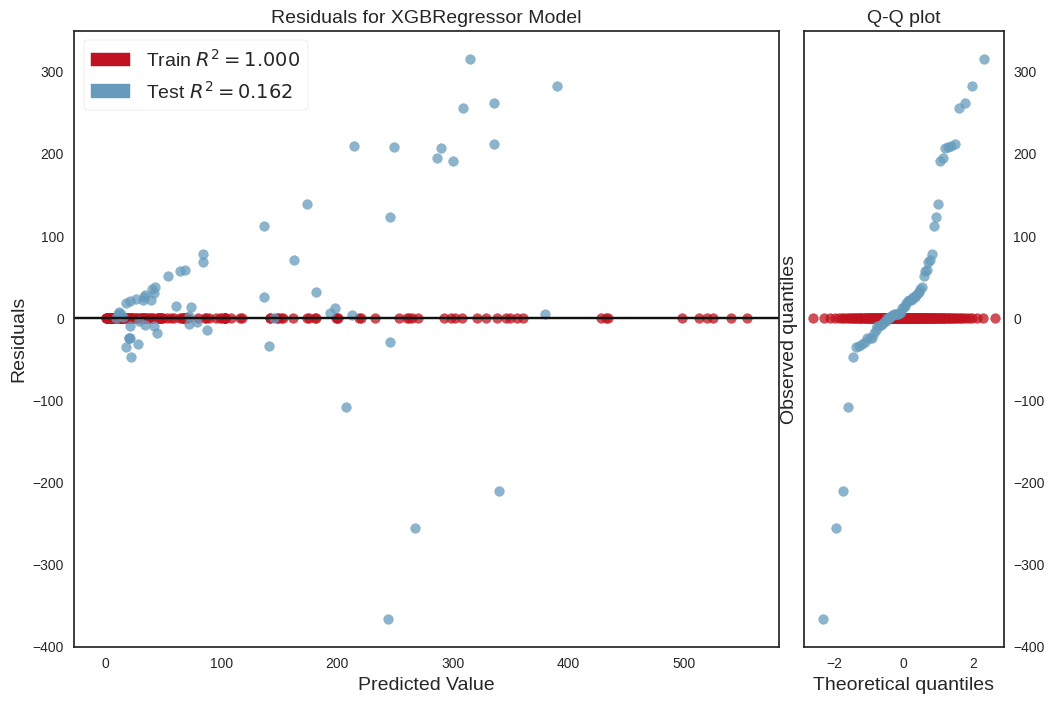

In [29]:
visualizer = ResidualsPlot(final_model,
                           train_color = colors[0],
                           test_color = colors[1],
                           hist = False,
                           qqplot = True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

Conclusion
The model performed slightly worse on the test data, however, it still maintained results very close to those performed on the training data, indicating that the model is not suffering from overfitting problems and is robust to new data. In addition, the value of RMSE, when compared to the target scale, is great, indicating that the model is able to predict the life expectancy of a particular country based on the other metrics provided.

By analyzing the errors made by the model, it is possible to notice that most of the errors occurred in countries where life expectancy is significantly above or below the average when compared to other countries. Therefore, the model is able to predict life expectancy well for most cases, but with room for improvement for extreme cases.

From the residuals plot, it can be noticed that the problem fits well to linear models, since the points are randomly scattered around the axis.

It is important to note that the model gives significant weight to the 'Total expenditure' variable, which is plausible, as this metric refers to government spending on health, indicating that countries that spend more on health for the population have higher life expectancy.